# 1. IMPORTATIONS AND DATA LOADING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

# Load data
df = load_data("C:/Users/Carlos/Downloads/dia.csv")
df.shape

(100000, 9)

# 2. CLEANING

## 2.1 Duplicates

In [2]:
## 2.1 Duplicates
print("Number of duplicate rows: ", df[df.duplicated()].shape)
df = remove_duplicates(df)

Number of duplicate rows:  (3854, 9)


In [3]:
df = df.drop_duplicates()

## 2.2 Counting distinct values

In [4]:
## 2.2 Counting distinct values
count_distinct_values(df)

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


## 2.3 Counting null values

In [5]:
## 2.3 Counting null values
count_null_values(df)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


## 2.4 Removing Unncessary values 0.00195%

In [6]:
## 2.4 Removing Unnecessary values
df = remove_unnecessary_values(df)
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


# 5. Correlations

In [7]:
# Recategorize smoking history
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [8]:
# One-hot encoding
data = df.copy()
data = perform_one_hot_encoding(data, 'gender')
data = perform_one_hot_encoding(data, 'smoking_history')

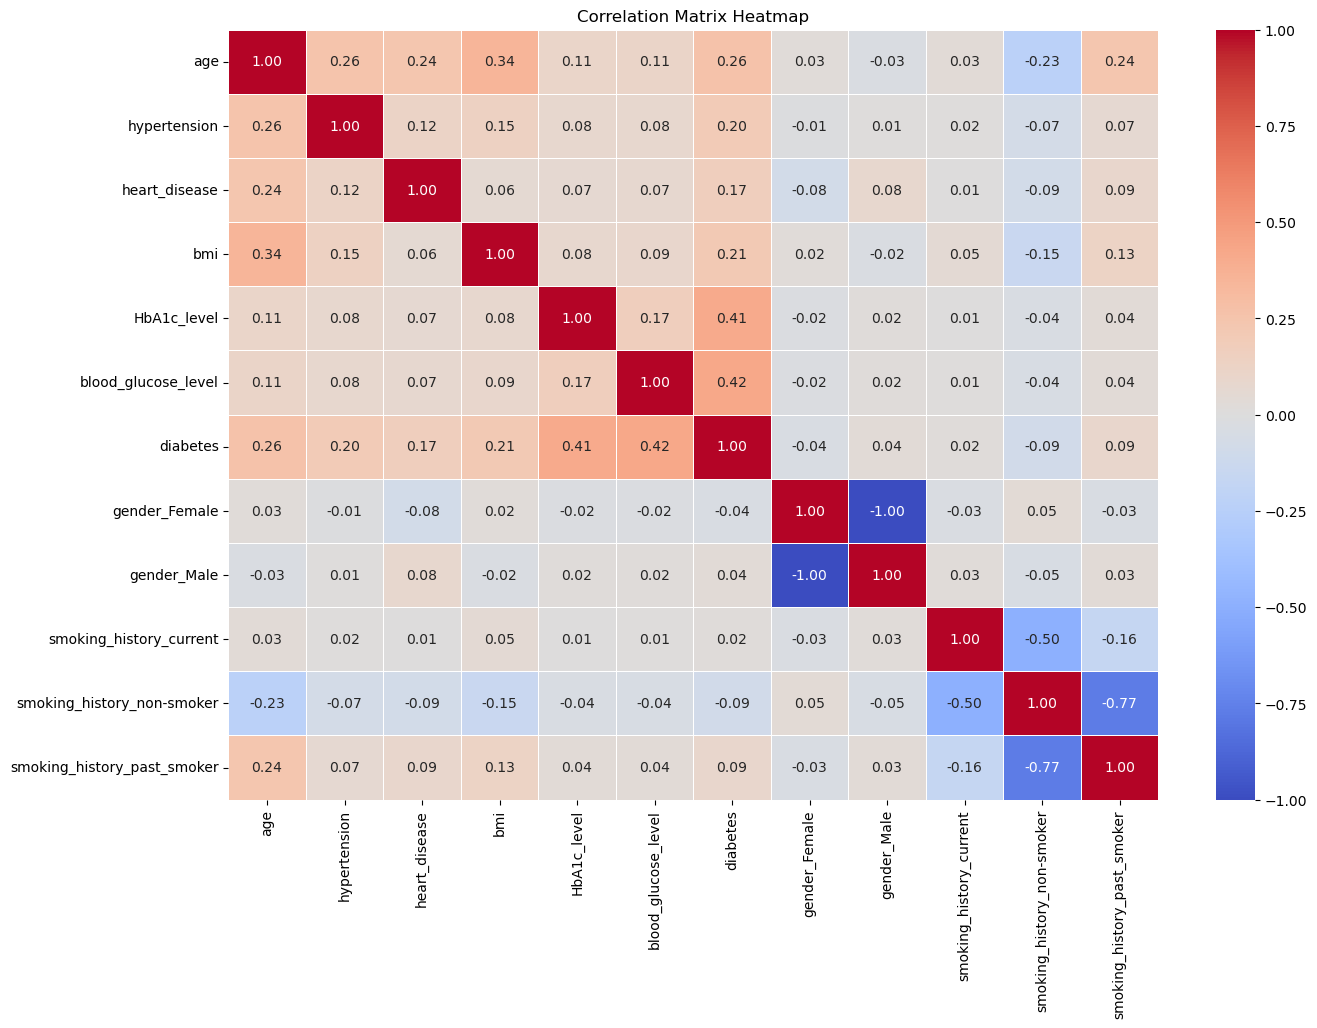

In [9]:
# Correlation matrix
correlation_matrix = data.corr()
plot_heatmap(correlation_matrix, "Correlation Matrix Heatmap")

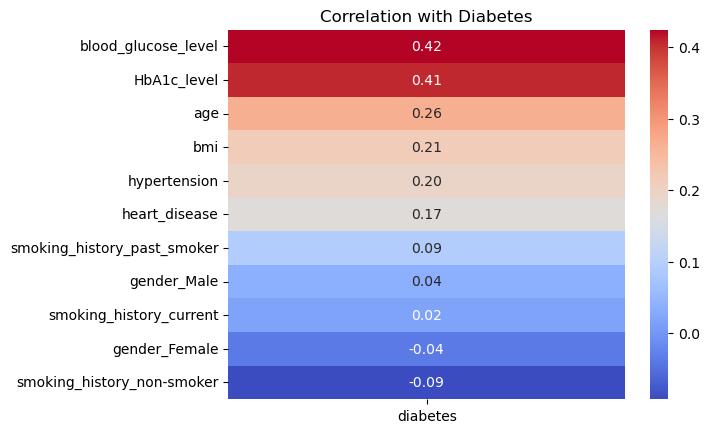

In [10]:
# Correlation with target
target_corr = correlation_matrix['diabetes'].drop('diabetes').sort_values(ascending=False)
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

# 6. ML

## 6.0 KKN

In [11]:
# Librerías adicionales
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
# 6.1 Definir características (X) y la variable objetivo (y)
# Define features and target
X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [13]:
# 6.2 Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# 6.3 Normalización de características numéricas
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# 6.4 Definir el modelo KNN
knn = train_knn(X_train, y_train, n_neighbors=3)

In [16]:
evaluate_model(knn, X_test, y_test)

Confusion Matrix:
[[17324   201]
 [  625  1076]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17525
           1       0.84      0.63      0.72      1701

    accuracy                           0.96     19226
   macro avg       0.90      0.81      0.85     19226
weighted avg       0.95      0.96      0.95     19226



In [17]:
# GridSearch for KNN
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid_search = perform_grid_search(KNeighborsClassifier(), param_grid, X_train, y_train, cv=5)
print("Best n_neighbors:", grid_search.best_params_)

Best Parameters:  {'n_neighbors': 9}
Best n_neighbors: {'n_neighbors': 9}


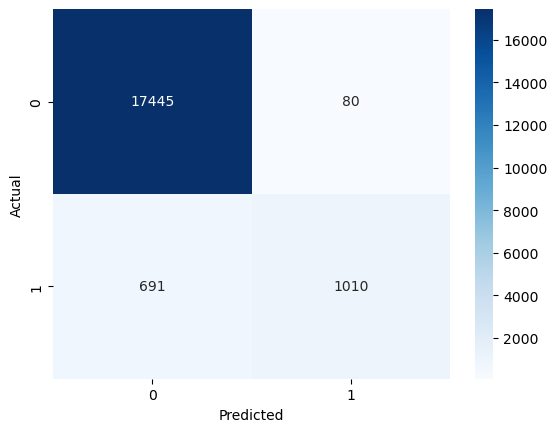

In [18]:
# Evaluate best model
y_pred = grid_search.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6.1 Logistic

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [20]:
X = df[["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level",]]
y = df['diabetes']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
log= LogisticRegression()
log.fit(X_train, y_train)

c:\Users\Carlos\anaconda3\envs\Statistics_Lab\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
log.score(X_test,y_test)

0.9567772807656298

In [24]:
log.score(X_train,y_train)

0.959337858573249

In [25]:
y_pred = log.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[17351   174]
 [  657  1044]]


In [27]:
from sklearn.metrics import recall_score

labels = np.unique(y_test)
print("Available labels:", labels)


pos_label = labels[0]

print('Recall:', recall_score(y_test, y_pred, pos_label=pos_label))



Available labels: [0 1]
Recall: 0.9900713266761769


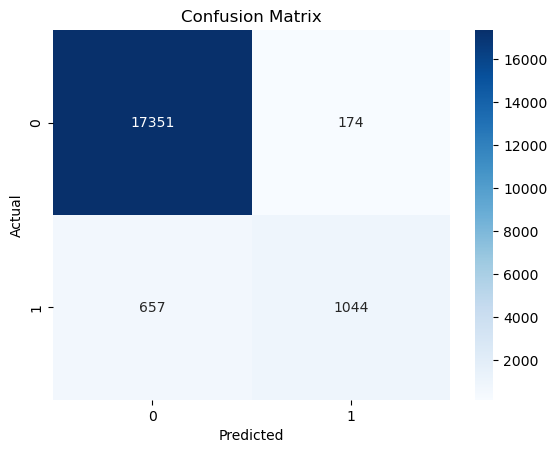

In [28]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 6.2 Random Forest

A través del EDA, vimos que el dataset estaba imbalanceado con un 9% de casos de diabetes frente a un 91% de casos negativos. Es esencial balancear la data para asegurarse que el model no esté sesgado hacia una clase mayoritaria. Por ello, se utiliza la técnica Over-Sampling Technique (SMOTE) la cuál genera muestras sintéticas para la clase minoritaria. 

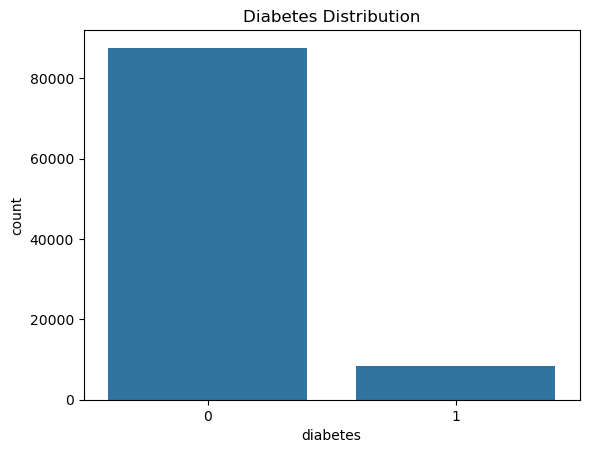

In [29]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [30]:
#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [31]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

### PROCESSING: SCALER

El preproceso es un paso crucial antes de entrenar un modelo. En este caso, las variables numericas son estandarizadas (lo que significa quitar y escalar a una única varianza), y las variables categóricas son coedificadas en una one-hot- La estandarización no se requiere para todos los modelos, pero es generalmente una buena práctica. La codificación one-hot es necesaria para que las variables categóricas puedan ser correctamente entendidas por el modelo de machine learning. 

El StandarScaler en sklearn está basado en la asunción de que la variable independiente Y, sigue una distribución que no necesariamente tiene que ser de tipo gausiano (normal), así que nosotros la vamos a estandarizar como una normal de media 0 y desviación típica 1. En otras palabras, dado un vector X, 
The StandardScaler in sklearn is based on the assumption that the data, Y, follows a distribution that might not necessarily be Gaussian (normal), but we still transform it in a way that its distribution will have a mean value 0 and standard deviation of 1. Esta transformación es conocida como Z-score normalization. 

In [32]:
#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [33]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [34]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

### Model Building and Hyperparameter Tuning

Un pipeline es construido con aquellas primeras aplicaciones de proceso de pasos y luego entrena un model de datos. Nosotros usamos un RandomForestClassifier, el cuál es un popular y poderoso algoritmo de clasificacion. Los hiperparametros del modelo son ajustados usando GridSearchCV, el cuál performa una exhaustiva búsqueda sobre los valores de los parámetros especificados por el estimador. El mejor modelo performador es seleccionado en validación cruzada. 

In [35]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [36]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


### Intepret the results

Los resultados muestran los mejores parametros para nuestro modelo de Random Fores que fueron encontrados durante el proceso de hyperparameter tuning: 

1. **max_depth of 10:** Esto indica que la máxima profundidad de árboles en el bosque son 10 niveles. Constriñendo la profundidad de los árboles ayuda a reducir el overfitting. Parece ser que de nuestros resultados, una complejidad media es la que mejor trabaja para nuestros datos. Demasiada complejidad (unos árboles más profundos) podría capturar ruido, y demasiado poca no subrayar la estructura de nuestros datos.

2. **min_samples_leaf of 2:** Esto significa que cada hoja (el final de un nodo de decisión del árbol, donde las predicciones son realizadas) debe contener al menos dos muestras. Este parámetro, como max_depth, es una forma de controlar el overfitting. Requiriendo de al menos dos muestras para hacer la predicción, el modelo previene de incluir outliers o ruido en los datos de entrenamiento.

3. **min_samples_split of 2:** Esto nos dice que un nodo debe contener al menos dos muestras para ser separadas (para crear dos sub-muestras). Su uso es similar al min_samples_leaf, puede ayudarnos a reducir el overfitting. 

4. **n_estimators of 50:** Este es el número de árboles de deicisón en nuestro bosque. El algoritmo de Random Forest trabaja promediando muchos árboles de decisiones para realizar una predicción final, que nos ayuda a reducir el overfitting y la varianza. En este caso, parece que teniendo 50 árboles nos da un muy buen resultado.

Estos parámetros son el resultado del proceso de Hyperparameter tuning, y nos dan una vista sobre la estructura de los datos y la complejidad del modelo que mejor captura su estructura. La constricción moderada de la profundidad del bosque y los requisitos de un número de muestras específico en cada nodo, sugiere que el modelo es lo suficientemente complejo para capturar los patrones importantes en los datos, pero no lo suficientemente complejo para que tenga los problemas de overfits, ruido u outliers. Este balance es crucial en la creación de un modelo que vaya a generalizar bien nuestra data. 

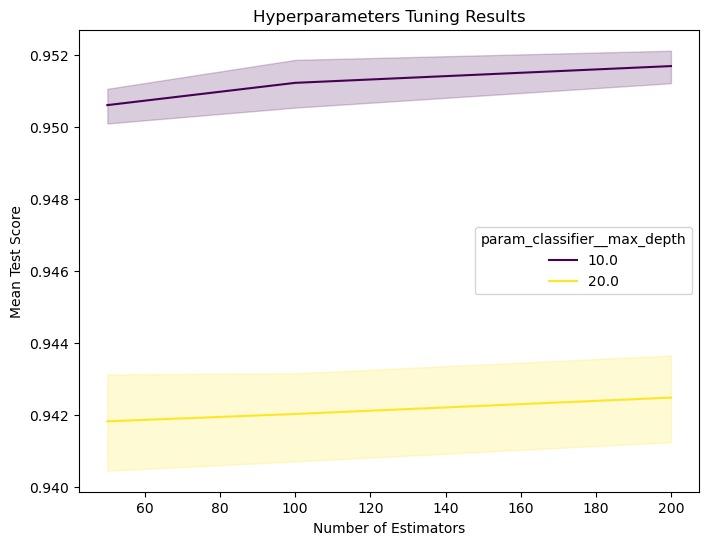

In [37]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

### Confusion Matrix

El modelo entrenado es evaluado en el test set. La matriz de confusión es usada para visualizar el resultado de un modelo. Esta matriz visualiza las predicciones con verdadero positivo, el verdadero negativo, el faso positivo y el falso negativo en nuestro modelo. 

Precision:

La precisión es una medida de cuantas predicciones verdaderas fuero realmente correctas. Es definidio como el número de verdaderos positivos (TP) dividido por la suma de Verdadero positivos (TP) y de Falsos Positivos (FP). 

Recall:

El Recall o sensibilidad es una medida de cuantos de los actuales casos positivos fueron correctamente identificados. Es definido comoe l número de verdaderos positivos dividods por la suma de verdaderos positivos y falsos negativos.

F1-Score:

La puntuación F1 es la media armónica de la Precisión y la sensibilidad, y busca encontrar el balance entre una buena precisión y sensibilidad. Es definido como dos veces el producto de la precisión y el recall, divido por la suma de la precisión y el recall. 

In all of these formulas:
    
True Positives (TP) are the cases in which we predicted yes (diabetes present), and the actual was also yes.
True Negatives (TN) are the cases in which we predicted no, and the actual was also no.
False Positives (FP) are the cases in which we predicted yes, but the actual was no.
False Negatives (FN) are the cases in which we predicted no, but the actual was yes.

Model Accuracy:  0.9517840424425258
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17525
           1       0.70      0.79      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.84      0.88      0.86     19226
weighted avg       0.95      0.95      0.95     19226



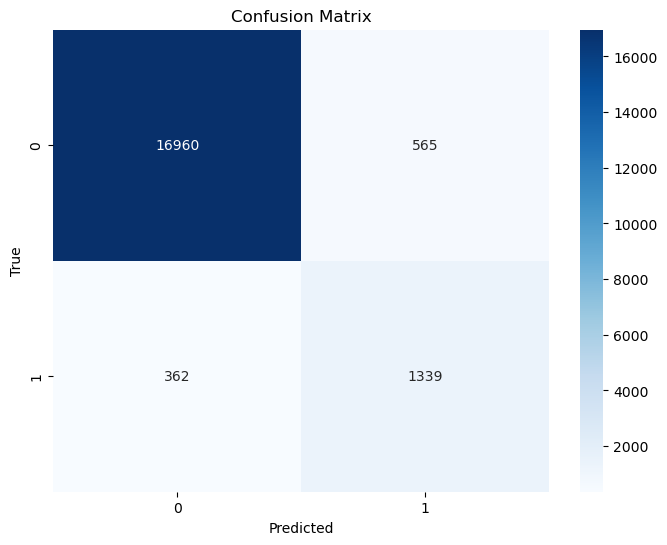

In [38]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Intepret the results

Nuestro Modelo de Random Forest entrenado alcanzó una eficiencia que ronda el 95%. Esto indica que el modelo clasifica correctamente el 95% de los casos del test set. 

Si miramos más profundamente las métricas de clasificación, podemos separar el resultado para cada clase (0 y 1) respectivamente: 

A | Class 0 (Non-diabetes):
- TEl modelo tiene una prición del 90% para la clase 0, lo que quiere decir que para el 98% de los casos de no-diabetes fueron predichos acertadamente. 
- El recall o sensibilidad para la clase 0 es también alta (96%). Lo que significa que el modelo identificó correctamente al 96% de los casos de no diabetes. 

B | Class 1 (Diabetes): 
- La precisión para la clase 1 (diabetes) es algo más baja de un 65%, lo que indica que cuando nuestro modelo predice la diabetes, fué correcto en el 65% más o menos. 
- Sin embargo, el recall es razonablemente alto (80%). Esto significa que nuestro modelo ha sido capaz de capturar el 80% de los casos de diabetes. 

El F1 Score, se encuentra sobre el 97% para la clase 0 y sobre el 72% para la clase 1. El peso de la media del F1 score está en el 94%, en línea con el total de la precisión. Esta discrepancia entre clases es mayormente debido al imbalance de datos de las dos clases en el dataset original, al ser la clase 0 la inmensa mayoría de la muestra y tener más ejemplos de los que el modelo puede aprender. Sin embargo, un recall mayor de la clase 1 es prometedor. Esto es un aspecto esencial en un modelo de salud, sobre todo de cara a que los falsos negativos pueden tener implicaciones serias en las conclusiones.   

                        Feature  Importance
2                   HbA1c_level    0.446878
3           blood_glucose_level    0.314852
0                           age    0.118161
1                           BMI    0.057917
4                  hypertension    0.034528
5                 heart_disease    0.017058
9    smoking_history_non-smoker    0.003848
10  smoking_history_past_smoker    0.003063
6                 gender_Female    0.001575
7                   gender_Male    0.001440
8       smoking_history_current    0.000681


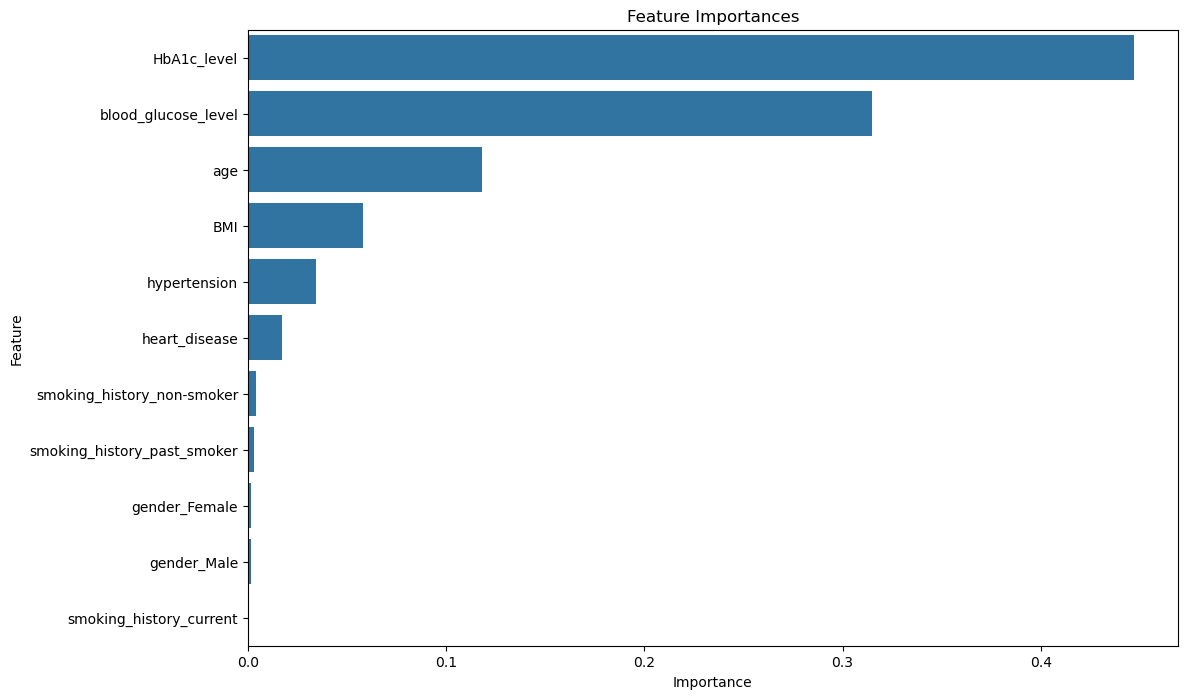

In [39]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

### Intepret the results

The feature importance results provide insight into which features are most influential in predicting diabetes using our Random Forest Model. The importance of a feature is calculated based on how much the tree nodes that use that feature reduce impurity across all trees in the forest.

Here are the key findings from the feature importance results:

1. **`HbA1c_level`** es la variable más importante con un 44%. Ya que es la media de los niveles de glucosa en sangre de los últimos 2-3 meses, concuerda con la lógica de ser un factor determinante.

2. **`The blood_glucose_level`** la segunda variable más importante con un 32%. Esto se alinea con el conocimiento médico, ya que los niveles de glucosa en sangre son usados en la detección directa de la diabetes.

3. **`Age`** La edad se encuadra con una importancia del 14%. El riesgo de diabetes (sobre todo de tipo 2 según la literatura) se incrementa con la edad. 

4. **`BMI`** En términos de importancia se sitúa como la cuarta, con un 6&. Se encuadra como un factor de riesgo de la diabetes.

5. Otras variables como la  **`hypertension`** y **`heart_disease`**  muestran alguna importancia 2% y 1% respectivamente, indicando esas condiciones de salud que podrían tener alguna relevancia prediciendo la diabetes, aunque definitivamente no son factores de riesgo a tener muy en cuenta.

6. **`Smoking history`** ('smoking_history_non-smoker', 'smoking_history_past_smoker', 'smoking_history_current') and **`gender`** ('gender_Female', 'gender_Male') are shown to have minimal or zero importance in our model. This could be due to a number of reasons including that these factors may not be as influential in the development of diabetes or it could be a result of how the data was collected or structured.